# DOWHY Causal Graph Analysis Example with Measurer

Hypothesis (Crop Rotation Impact):
**Crop rotation index** has a positive (or negative) effect on **species richness**.

The goal is to prove/disprove the above hypothesis.

DoWhy automatically considers the rest of the variables as potential confounders.

After creating the casual graph, we need to identify the casual effect, estimate it (numerical value) and refute it (i.e. validate the estimation)

## Setup the Measurer

In [1]:
# silent install of required additional packages for the user
!pip install loguru codecarbon --quiet --user --no-warn-script-location

In [2]:
# get logger, and initialise a measurer tracker
import sys
from loguru import logger
from measurer.measurer import Measurer
from types import ModuleType

#logger.remove(0)
logger.add(sys.stdout, level='INFO')

1

## Setup the Model

In [3]:
# silent install of required additional packages for the user
!pip install networkx dowhy --quiet --user --no-warn-script-location

In [4]:
import networkx as nx
import rasterio
import pandas as pd
import numpy as np
import os
from pathlib import Path
from dowhy import CausalModel
from dowhy import plotter

In [5]:
# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [6]:
# Get the directory of the current script
script_dir = Path.cwd()  # or os.getcwd()

# Define the relative path to the data
relative_path = Path("../../s3/uc2-data/CML")

# path to the data
data_path = (script_dir / relative_path).resolve()

print("Data path:", data_path)


Data path: /home/robknapen/s3/uc2-data/CML


## Read data 

In [7]:
# Function to read raster data
def read_raster(file_name, file_path):
    file_path = file_path / file_name
    if not file_path.exists():
        print(f"Error: File {file_name} not found in {data_path}")
        return None
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Read the first band
        affine = src.transform
        return data, affine

In [8]:
# Read rasters
treatment_crop_rotation, _ = read_raster("CRI.tif",data_path)
outcome, _ = read_raster("normalized_richness_arable.tif",data_path)
# outcome, _ = read_raster("MaxEnt_graspieper_arable.tif",data_bird_path)
LGN_confounder, _ = read_raster("LGN_2018_arable_r2.tif",data_path)
SWF_covariate, _ = read_raster("SWF_2018_arable_r2.tif",data_path)
spring_greenness_covariate, _ = read_raster("greenness_spring.tif",data_path)
autumn_greenness_covariate, _ = read_raster("greenness_autumn.tif",data_path)

In [9]:
# Flatten all rasters
# rows, cols = treatment_crop_rotation.shape
treatment_crop_rotation_flat = treatment_crop_rotation.flatten()
outcome_flat = outcome.flatten()
LGN_confounder_flat = LGN_confounder.flatten()
SWF_covariate_flat = SWF_covariate.flatten()
spring_greenness_covariate_flat = spring_greenness_covariate.flatten()
autumn_greenness_covariate_flat = autumn_greenness_covariate.flatten()

In [10]:
df = pd.DataFrame({
    "treatment_crop_rotation": treatment_crop_rotation_flat,
    "outcome": outcome_flat,
    "LGN_confounder": LGN_confounder_flat,
    "SWF_covariate": SWF_covariate_flat,
    "spring_greenness_covariate": spring_greenness_covariate_flat,
    "autumn_greenness_covariate": autumn_greenness_covariate_flat,
})

In [11]:
df['outcome'] = df['outcome'].fillna(df['outcome'].mean())

In [12]:
df.corr()

,treatment_crop_rotation,outcome,LGN_confounder,SWF_covariate,spring_greenness_covariate,autumn_greenness_covariate
treatment_crop_rotation,1.000000,0.232999,-0.148995,-0.156729,0.013302,0.009969
outcome,0.232999,1.000000,-0.304165,-0.145344,0.551157,0.532336
LGN_confounder,-0.148995,-0.304165,1.000000,0.122590,-0.232059,-0.228146
SWF_covariate,-0.156729,-0.145344,0.122590,1.000000,-0.169255,-0.165429
spring_greenness_covariate,0.013302,0.551157,-0.232059,-0.169255,1.000000,0.947480
autumn_greenness_covariate,0.009969,0.532336,-0.228146,-0.165429,0.947480,1.000000


In [13]:
df.dtypes

treatment_crop_rotation       float32
outcome                       float32
LGN_confounder                 uint16
SWF_covariate                   uint8
spring_greenness_covariate     uint16
autumn_greenness_covariate     uint16
dtype: object

In [14]:
print(df.isnull().sum())  # Check for missing values
# df.describe()

treatment_crop_rotation       0
outcome                       0
LGN_confounder                0
SWF_covariate                 0
spring_greenness_covariate    0
autumn_greenness_covariate    0
dtype: int64


In [15]:
# Assuming df is your dataframe before running DoWhy
df['SWF_covariate'].describe()

count    5.627244e+06
mean     4.716909e-02
std      2.120004e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: SWF_covariate, dtype: float64

In [16]:
# Define the causal graph structure
causal_graph = """
digraph {
    treatment_crop_rotation -> outcome;
    spring_greenness_covariate -> outcome;
    autumn_greenness_covariate -> outcome;
    SWF_covariate -> outcome;
    LGN_confounder -> treatment_crop_rotation;
    LGN_confounder -> outcome;
}
"""

# Create causal model
model = CausalModel(
    data=df, 
    treatment="treatment_crop_rotation",
    outcome="outcome",
    common_causes=['spring_greenness_covariate','autumn_greenness_covariate','SWF_covariate'], # should be all covariates
    graph=causal_graph
)

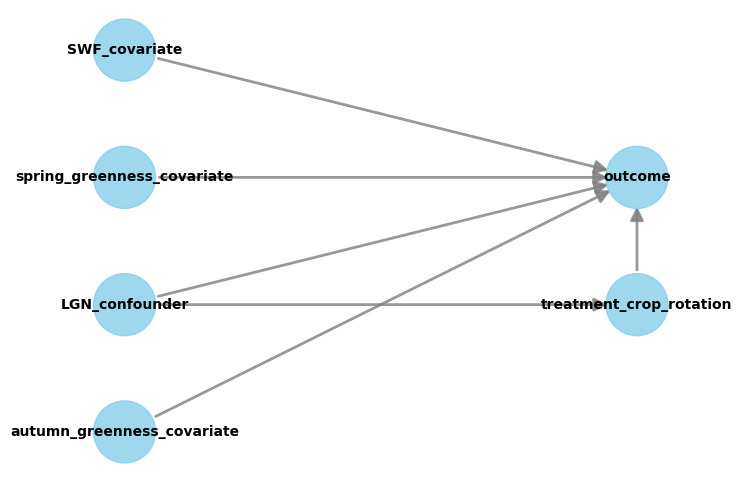

In [17]:
# Display the graph for verification
model.view_model()

### Identify casual effect
What does it mean?
- It ensures that the causal effect we want to estimate is valid under the assumptions of our graph.
- Provides a blueprint for how the effect can be estimated from our data.
- It is important for the next step which is estimating the effect

In [18]:
# logger for the next step
measurer_estimand = Measurer()
tracker_estimand = measurer_estimand.start(logger=logger)

2025-03-25 10:15:25.129 | INFO     | measurer.measurer:start:288 - Started computational costs meter: wall time, memory consumed, network traffic, CO2 emissions, data size


2025-03-25 10:15:25.129 | INFO     | measurer.measurer:start:288 - Started computational costs meter: wall time, memory consumed, network traffic, CO2 emissions, data size


In [19]:
# Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("Identified Estimand:")
print(identified_estimand)

Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                        
──────────────────────────(E[outcome|LGN_confounder])
d[treatment_crop_rotation]                           
Estimand assumption 1, Unconfoundedness: If U→{treatment_crop_rotation} and U→outcome then P(outcome|treatment_crop_rotation,LGN_confounder,U) = P(outcome|treatment_crop_rotation,LGN_confounder)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [20]:
# save the measurer output for the step
measurer_estimand.end(
    tracker=tracker_estimand,
    shape=[],
    libraries=[k for k,v in globals().items() if type(v) is ModuleType and not k.startswith('__')],
    #program_path=__file__,
    variables=locals(),
    csv_file='benchmarks_dowhy_causalml_estimand_arable_cri.csv',
    logger=logger
)

2025-03-25 10:15:33.745 | INFO     | measurer.measurer:end:317 - Stopped computational costs meter. Results saved at


2025-03-25 10:15:33.745 | INFO     | measurer.measurer:end:317 - Stopped computational costs meter. Results saved at
                                    Measure  \
0                 Data size in grid points    
1   Largest allocated array in grid points    
2                            Data size (MB)   
3                            Data read (MB)   
4                         Data written (MB)   
5                Main memory available (MB)   
6                 Main memory consumed (MB)   
7      Sum of allocated variable sizes (MB)   
8                    Description of CPU/GPU   
9                             Wall time (s)   
10                      Energy consumed (W)   
11              CO₂-equivalents [CO₂eq] (g)   
12                     Network traffic (MB)   
13                     Programming language   
14                      Essential libraries   

                                                Value  
0                                                      
1                 

### Summary of the result:

**Backdoor Criterion:**
The backdoor path is valid, meaning we can estimate the causal effect by adjusting for observed confounders.

**Assumes Unconfoundedness:**
There are no unobserved confounders influencing both crop rotation frequency and outcome.

**Instrumental Variable (IV):**
No valid IV was found in our model. Therefore, IV methods are not applicable. IVs are special variables that affect the treatment but not the outcome directly (except through the treatment). Since I didn't specify an IV, this is expected.

**Frontdoor Criterion:**
No valid frontdoor paths were identified, indicating no mediators are present that could be used to estimate the causal effect.



# Estimate casual effect

This command computes the actual numerical value of the causal effect of the treatment on the outcome.

In [21]:
# import statsmodels.api as sm

# causal_estimate = model.estimate_effect(
#     identified_estimand,
#     method_name="backdoor.generalized_linear_model",
#     method_params={"glm_family": sm.families.Gaussian()}
# )    
# print(f"{method}: {causal_estimate.value}")

In [22]:
# logger for the next step
measurer_estimate = Measurer()
tracker_estimate = measurer_estimate.start(logger=logger)

2025-03-25 10:15:37.869 | INFO     | measurer.measurer:start:288 - Started computational costs meter: wall time, memory consumed, network traffic, CO2 emissions, data size


2025-03-25 10:15:37.869 | INFO     | measurer.measurer:start:288 - Started computational costs meter: wall time, memory consumed, network traffic, CO2 emissions, data size


In [23]:
# Estimate the causal effect using linear regression
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
# print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

Causal Estimate is 0.3280770229857681


In [24]:
# save the measurer output for the step
measurer_estimate.end(
    tracker=tracker_estimate,
    shape=[],
    libraries=[k for k,v in globals().items() if type(v) is ModuleType and not k.startswith('__')],
    #program_path=__file__,
    variables=locals(),
    csv_file='benchmarks_dowhy_causalml_estimate_arable_cri.csv',
    logger=logger
)

2025-03-25 10:15:51.611 | INFO     | measurer.measurer:end:317 - Stopped computational costs meter. Results saved at


2025-03-25 10:15:51.611 | INFO     | measurer.measurer:end:317 - Stopped computational costs meter. Results saved at
                                    Measure  \
0                 Data size in grid points    
1   Largest allocated array in grid points    
2                            Data size (MB)   
3                            Data read (MB)   
4                         Data written (MB)   
5                Main memory available (MB)   
6                 Main memory consumed (MB)   
7      Sum of allocated variable sizes (MB)   
8                    Description of CPU/GPU   
9                             Wall time (s)   
10                      Energy consumed (W)   
11              CO₂-equivalents [CO₂eq] (g)   
12                     Network traffic (MB)   
13                     Programming language   
14                      Essential libraries   

                                                Value  
0                                                      
1                 

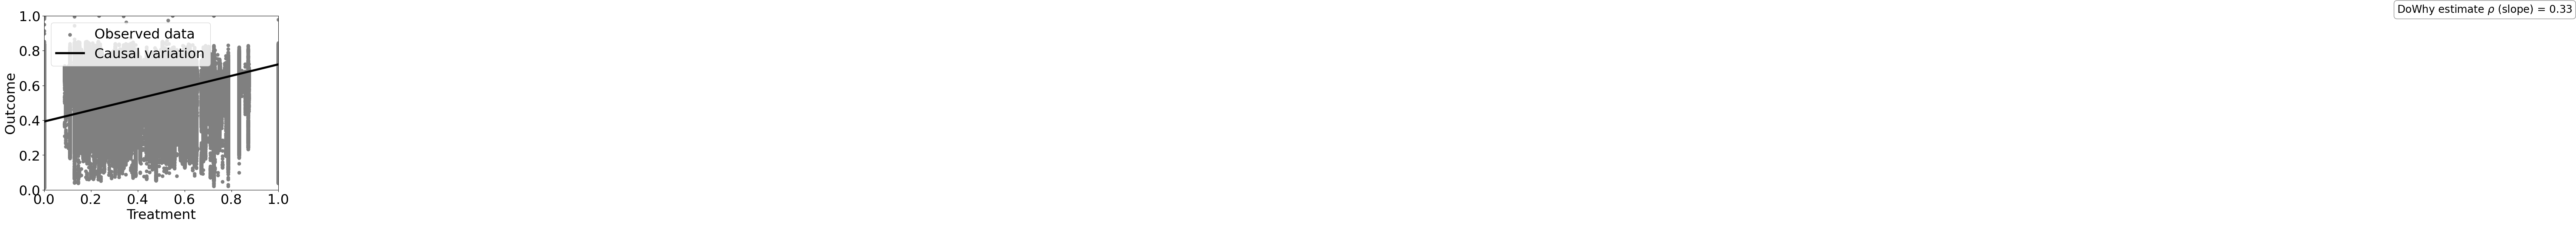

In [25]:
plotter.plot_causal_effect(causal_estimate,treatment = df["treatment_crop_rotation"], outcome=df["outcome"])

## Refute estimate
This function evaluates the robustness of the estimated causal effect by applying a placebo test. This is part of the refutation tests provided by DoWhy to validate causal estimates.

In [26]:
# # Refute the causal estimate
# refutation = model.refute_estimate(
#     identified_estimand, causal_estimate, method_name="placebo_treatment_refuter",show_progress_bar=True
# )
# print("\nRefutation Result:")

**Result Details**
Refutation Result:
- Refute: Use a Placebo Treatment
- Estimated effect:0.3280770229854436
- New effect:0.0
- p value:1.0


*Estimated Effect:*
This is the original causal estimate obtained from the model. It suggests that a one-unit increase in the treatment variable (crop_rotation_frequency) results in a 0.328-unit increase in species_abundance, on average.

*New Effect (Placebo Estimate):*
This is the causal effect estimated using the randomly generated placebo treatment variable. Ideally, this should be close to 0, as the placebo variable should have no causal relationship with the outcome.

*p-value:*
The p-value indicates the likelihood of observing the difference between the estimated effect and the placebo effect if the original estimate were valid.
A high p-value (typically above 0.05) suggests that the placebo effect is not significantly different from the original causal estimate. This weakens confidence in the robustness of the causal estimate.


In [27]:
# logger for the next step
measurer_refute = Measurer()
tracker_refute = measurer_refute.start(logger=logger)

2025-03-25 10:16:08.456 | INFO     | measurer.measurer:start:288 - Started computational costs meter: wall time, memory consumed, network traffic, CO2 emissions, data size


2025-03-25 10:16:08.456 | INFO     | measurer.measurer:start:288 - Started computational costs meter: wall time, memory consumed, network traffic, CO2 emissions, data size


In [28]:
refute_hidden_confounders = model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause",show_progress_bar=True)
print(refute_hidden_confounders)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Add a random common cause
Estimated effect:0.3280770229857681
New effect:0.3280770109701303
p value:0.94



If the relationship between treatment and outcome remains the same after controlling for "random_common_cause", then we have stronger evidence that treatment causes outcome. 
A p-value above 0.05 means there is no detectable statistical difference between the estimated causal effect before and after introducing the random common cause.

In [29]:
# save the measurer output for the step
measurer_refute.end(
    tracker=tracker_refute,
    shape=[],
    libraries=[k for k,v in globals().items() if type(v) is ModuleType and not k.startswith('__')],
    #program_path=__file__,
    variables=locals(),
    csv_file='benchmarks_dowhy_causalml_refute_arable_cri.csv',
    logger=logger
)

2025-03-25 10:22:30.124 | INFO     | measurer.measurer:end:317 - Stopped computational costs meter. Results saved at


2025-03-25 10:22:30.124 | INFO     | measurer.measurer:end:317 - Stopped computational costs meter. Results saved at
                                    Measure  \
0                 Data size in grid points    
1   Largest allocated array in grid points    
2                            Data size (MB)   
3                            Data read (MB)   
4                         Data written (MB)   
5                Main memory available (MB)   
6                 Main memory consumed (MB)   
7      Sum of allocated variable sizes (MB)   
8                    Description of CPU/GPU   
9                             Wall time (s)   
10                      Energy consumed (W)   
11              CO₂-equivalents [CO₂eq] (g)   
12                     Network traffic (MB)   
13                     Programming language   
14                      Essential libraries   

                                                Value  
0                                                      
1                 